Overall, all models were poor-performing.

In [1]:
%%time
import numpy as np
# from tempfile import TemporaryFile
import os
import pickle
import random 
import operator
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import time

CPU times: user 1.03 s, sys: 454 ms, total: 1.48 s
Wall time: 5.11 s


In [2]:
%%time
import librosa 
import librosa.display

CPU times: user 683 ms, sys: 572 ms, total: 1.26 s
Wall time: 5min 44s


In [3]:
import tensorflow as tf

2022-04-23 11:17:22.932283: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
blue_sig1, blue_sr1 = librosa.load("../data/blues/blues.00019.wav",sr=None)
blue_sig1.shape

(661794,)

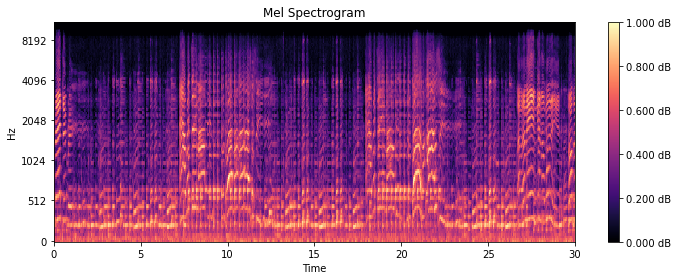

In [26]:
Dm = librosa.feature.melspectrogram(y=blue_sig1, sr=blue_sr1)
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    (librosa.power_to_db(Dm,ref=np.max)+80)/80, y_axis='mel', x_axis='time')
plt.colorbar(format='%.3f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()

In [20]:
librosa.power_to_db(Dm,ref=np.max) +80

array([[41.766964, 50.32847 , 52.884174, ..., 56.15498 , 52.94828 ,
        49.67182 ],
       [45.320667, 48.4983  , 50.974266, ..., 53.5951  , 50.141644,
        52.080776],
       [44.81101 , 45.47728 , 44.83068 , ..., 48.74622 , 49.661716,
        49.532547],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [27]:
%%time
directory = "../data/"
data = []
classes = []
for folder in os.listdir(directory):
    if folder=="mf_files":
        continue
    for file in os.listdir(directory+folder):  
        sig, rate = librosa.load(directory+folder+"/"+file)
        mel = librosa.feature.melspectrogram(y=sig, sr=rate)
        # scale to between 0 and 1
        mel_db = (librosa.power_to_db(mel, ref= np.max)+80)/80
        data.append(mel_db)
        classes.append(folder)

CPU times: user 2min 58s, sys: 12.4 s, total: 3min 10s
Wall time: 48.2 s


In [28]:
poor_data = []
for i in range(len(data)):
#     print(data[i].shape)
    if data[i].shape != (128,1293):
        print(i, "\t", data[i].shape)
        poor_data.append(i)
print(len(poor_data))

4 	 (128, 1305)
64 	 (128, 1308)
65 	 (128, 1310)
73 	 (128, 1292)
83 	 (128, 1292)
112 	 (128, 1292)
113 	 (128, 1308)
148 	 (128, 1292)
155 	 (128, 1307)
162 	 (128, 1303)
167 	 (128, 1296)
169 	 (128, 1292)
170 	 (128, 1297)
185 	 (128, 1296)
405 	 (128, 1300)
427 	 (128, 1308)
437 	 (128, 1294)
440 	 (128, 1304)
463 	 (128, 1308)
473 	 (128, 1303)
487 	 (128, 1301)
490 	 (128, 1313)
606 	 (128, 1314)
608 	 (128, 1296)
615 	 (128, 1309)
617 	 (128, 1296)
646 	 (128, 1292)
647 	 (128, 1300)
671 	 (128, 1292)
696 	 (128, 1308)
703 	 (128, 1298)
747 	 (128, 1296)
755 	 (128, 1305)
756 	 (128, 1299)
765 	 (128, 1305)
791 	 (128, 1292)
798 	 (128, 1305)
799 	 (128, 1302)
800 	 (128, 1320)
801 	 (128, 1320)
804 	 (128, 1320)
805 	 (128, 1305)
810 	 (128, 1305)
811 	 (128, 1320)
814 	 (128, 1300)
815 	 (128, 1320)
822 	 (128, 1308)
831 	 (128, 1308)
832 	 (128, 1320)
845 	 (128, 1298)
846 	 (128, 1320)
852 	 (128, 1290)
859 	 (128, 1292)
870 	 (128, 1320)
877 	 (128, 1320)
896 	 (128, 1320

In [29]:
usable_data = np.stack([element for i,element in enumerate(data) if i not in poor_data])
usable_classes = np.array([element for i,element in enumerate(classes) if i not in poor_data])

In [30]:
print(usable_data.shape)
print(usable_classes.shape)

(944, 128, 1293)
(944,)


In [31]:
label_dict = {}
for i, element in enumerate(np.unique(usable_classes)):
    label_dict[element] = i
print(label_dict)
# convert from string to int

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [32]:
usable_labels = np.array([label_dict[element] for element in list(usable_classes)])

In [33]:
inv_labels = {v: k for k, v in label_dict.items()}

In [34]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(usable_data, 
                                                usable_labels,
                                                test_size = 0.25, 
                                                random_state=29,
                                                stratify = usable_labels)

Overfitting:
* Regularization
* Batch Normalization
* Dropout Layers:
    * tf.keras.layers.Dropout(rate=0.2) 
    * 0.20-0.3 in RNN and 0.4-.5 in CNN

Try with ReLU layers
or Elu or SELU layers:
* tf.keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu')
* tf.keras.layers.Dense(64, kernel_initializer='he_normal',
                                activation= 'elu')
                                


In [35]:
def plot_results(fit):
    plt.figure(figsize=(20,15))
    fig, ax = plt.subplots(2)
    # accuracy subplot
    ax[0].plot(fit.history["accuracy"], label="train")
    ax[0].plot(fit.history["val_accuracy"], label="test")    
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(loc="lower right")
    ax[0].set_title("Accuracy")
    
    # Error subplot
    ax[1].plot(fit.history["loss"], label="train error")
    ax[1].plot(fit.history["val_loss"], label="test error")    
    ax[1].set_ylabel("Error")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(loc="upper right")
    ax[1].set_title("Error")
    plt.tight_layout()
    plt.show()

In [36]:
train_times = []

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 165504)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               84738560  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)              

23/23 [==============================] - 2s 71ms/step - loss: 2.8021 - accuracy: 0.1103 - val_loss: 2.7928 - val_accuracy: 0.1059
Epoch 47/100
23/23 [==============================] - 2s 71ms/step - loss: 2.7951 - accuracy: 0.1142 - val_loss: 2.7810 - val_accuracy: 0.1059
Epoch 48/100
23/23 [==============================] - 2s 71ms/step - loss: 2.7803 - accuracy: 0.1158 - val_loss: 2.7770 - val_accuracy: 0.1059
Epoch 49/100
23/23 [==============================] - 2s 71ms/step - loss: 2.7742 - accuracy: 0.1002 - val_loss: 2.7708 - val_accuracy: 0.1059
Epoch 50/100
23/23 [==============================] - 2s 71ms/step - loss: 2.7699 - accuracy: 0.0937 - val_loss: 2.7663 - val_accuracy: 0.1059
Epoch 51/100
23/23 [==============================] - 2s 71ms/step - loss: 2.7671 - accuracy: 0.0884 - val_loss: 2.7626 - val_accuracy: 0.1059
Epoch 52/100
23/23 [==============================] - 2s 73ms/step - loss: 2.7606 - accuracy: 0.1221 - val_loss: 2.7590 - val_accuracy: 0.1059
Epoch 53/100

<Figure size 1440x1080 with 0 Axes>

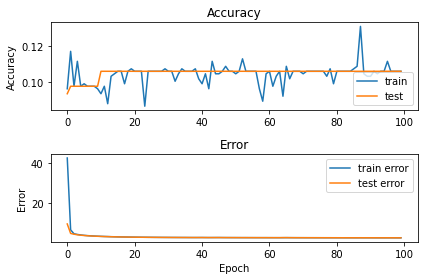

0.1059322033898305
CPU times: user 1min 38s, sys: 45.9 s, total: 2min 24s
Wall time: 2min 45s


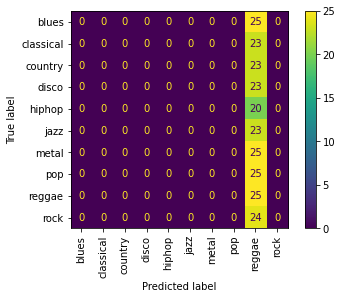

In [37]:
%%time
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(trainX.shape[1], trainX.shape[2])),
    tf.keras.layers.Dense(512, activation= "relu", 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.01),
    tf.keras.layers.Dense(512, activation = "relu", 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.03),
    tf.keras.layers.Dense(512, activation = "relu", 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.01),
    tf.keras.layers.Dense(128, activation = "relu", 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.01),
    tf.keras.layers.Dense(10, activation = "linear")
])
## get output layer as logits for each class 
##(we can use softmax to get probabilities, but doing so makes model unstable:
# https://www.tensorflow.org/tutorials/quickstart/beginner
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start = time.time()
fit = model.fit(trainX, trainY,
         validation_data = (testX,testY),
                 epochs = 100)
stop = time.time()
train_times.append(stop-start)


plot_results(fit)

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(testX)
pred_labels = [np.argmax(prediction) for i,prediction in enumerate(predictions)]

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

ConfusionMatrixDisplay.from_predictions(
    y_true = [inv_labels[e] for i,e in enumerate(testY)],
    y_pred = [inv_labels[e] for i,e in enumerate(pred_labels)], 
    xticks_rotation= "vertical")
print(accuracy_score(testY,pred_labels))

### With Selu

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 165504)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               84738560  
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)             

23/23 [==============================] - 2s 70ms/step - loss: 1.9852 - accuracy: 0.4716 - val_loss: 2.5608 - val_accuracy: 0.3136
Epoch 47/300
23/23 [==============================] - 2s 70ms/step - loss: 2.1613 - accuracy: 0.3930 - val_loss: 2.1223 - val_accuracy: 0.3602
Epoch 48/300
23/23 [==============================] - 2s 70ms/step - loss: 1.9860 - accuracy: 0.4714 - val_loss: 2.9955 - val_accuracy: 0.2203
Epoch 49/300
23/23 [==============================] - 2s 71ms/step - loss: 2.5453 - accuracy: 0.3340 - val_loss: 2.2304 - val_accuracy: 0.3898
Epoch 50/300
23/23 [==============================] - 2s 72ms/step - loss: 2.1437 - accuracy: 0.4401 - val_loss: 2.3946 - val_accuracy: 0.3136
Epoch 51/300
23/23 [==============================] - 2s 72ms/step - loss: 1.9683 - accuracy: 0.4818 - val_loss: 2.1621 - val_accuracy: 0.4322
Epoch 52/300
23/23 [==============================] - 2s 72ms/step - loss: 1.8026 - accuracy: 0.5398 - val_loss: 2.7711 - val_accuracy: 0.2797
Epoch 53/300

23/23 [==============================] - 2s 69ms/step - loss: 2.2707 - accuracy: 0.4282 - val_loss: 2.6569 - val_accuracy: 0.3178
Epoch 104/300
23/23 [==============================] - 2s 69ms/step - loss: 2.0303 - accuracy: 0.5067 - val_loss: 2.3200 - val_accuracy: 0.4110
Epoch 105/300
23/23 [==============================] - 2s 70ms/step - loss: 1.7232 - accuracy: 0.5805 - val_loss: 2.7124 - val_accuracy: 0.3432
Epoch 106/300
23/23 [==============================] - 2s 68ms/step - loss: 2.0715 - accuracy: 0.5218 - val_loss: 3.1122 - val_accuracy: 0.3347
Epoch 107/300
23/23 [==============================] - 2s 69ms/step - loss: 1.9091 - accuracy: 0.5854 - val_loss: 2.5239 - val_accuracy: 0.4449
Epoch 108/300
23/23 [==============================] - 2s 69ms/step - loss: 2.1228 - accuracy: 0.4613 - val_loss: 2.2724 - val_accuracy: 0.4068
Epoch 109/300
23/23 [==============================] - 2s 70ms/step - loss: 1.8228 - accuracy: 0.5279 - val_loss: 2.5114 - val_accuracy: 0.3856
Epoch 

Epoch 160/300
23/23 [==============================] - 2s 70ms/step - loss: 1.5490 - accuracy: 0.7183 - val_loss: 3.3331 - val_accuracy: 0.4025
Epoch 161/300
23/23 [==============================] - 2s 72ms/step - loss: 2.1348 - accuracy: 0.5532 - val_loss: 2.8508 - val_accuracy: 0.3517
Epoch 162/300
23/23 [==============================] - 2s 72ms/step - loss: 2.0630 - accuracy: 0.4941 - val_loss: 3.5344 - val_accuracy: 0.2924
Epoch 163/300
23/23 [==============================] - 2s 72ms/step - loss: 1.8800 - accuracy: 0.5491 - val_loss: 4.3748 - val_accuracy: 0.2288
Epoch 164/300
23/23 [==============================] - 2s 73ms/step - loss: 2.3089 - accuracy: 0.5452 - val_loss: 3.0368 - val_accuracy: 0.3771
Epoch 165/300
23/23 [==============================] - 2s 72ms/step - loss: 1.9342 - accuracy: 0.7000 - val_loss: 2.8478 - val_accuracy: 0.4025
Epoch 166/300
23/23 [==============================] - 2s 73ms/step - loss: 1.7750 - accuracy: 0.6338 - val_loss: 2.6777 - val_accuracy:

Epoch 217/300
23/23 [==============================] - 2s 69ms/step - loss: 1.3128 - accuracy: 0.8360 - val_loss: 2.7913 - val_accuracy: 0.4068
Epoch 218/300
23/23 [==============================] - 2s 69ms/step - loss: 1.5622 - accuracy: 0.6924 - val_loss: 3.1926 - val_accuracy: 0.3178
Epoch 219/300
23/23 [==============================] - 2s 69ms/step - loss: 1.5013 - accuracy: 0.7060 - val_loss: 3.7517 - val_accuracy: 0.3432
Epoch 220/300
23/23 [==============================] - 2s 70ms/step - loss: 1.7539 - accuracy: 0.6280 - val_loss: 3.0099 - val_accuracy: 0.3898
Epoch 221/300
23/23 [==============================] - 2s 70ms/step - loss: 1.7582 - accuracy: 0.6483 - val_loss: 3.9101 - val_accuracy: 0.2881
Epoch 222/300
23/23 [==============================] - 2s 71ms/step - loss: 2.8251 - accuracy: 0.4560 - val_loss: 3.1247 - val_accuracy: 0.3941
Epoch 223/300
23/23 [==============================] - 2s 70ms/step - loss: 1.6513 - accuracy: 0.7342 - val_loss: 4.0817 - val_accuracy:

Epoch 274/300
23/23 [==============================] - 2s 71ms/step - loss: 2.8085 - accuracy: 0.8301 - val_loss: 3.9858 - val_accuracy: 0.4110
Epoch 275/300
23/23 [==============================] - 2s 70ms/step - loss: 2.4999 - accuracy: 0.8263 - val_loss: 4.4417 - val_accuracy: 0.4068
Epoch 276/300
23/23 [==============================] - 2s 71ms/step - loss: 2.1770 - accuracy: 0.7773 - val_loss: 3.1623 - val_accuracy: 0.4619
Epoch 277/300
23/23 [==============================] - 2s 72ms/step - loss: 1.5794 - accuracy: 0.7786 - val_loss: 3.6776 - val_accuracy: 0.3136
Epoch 278/300
23/23 [==============================] - 2s 72ms/step - loss: 1.7491 - accuracy: 0.7212 - val_loss: 3.6599 - val_accuracy: 0.4068
Epoch 279/300
23/23 [==============================] - 2s 72ms/step - loss: 2.3797 - accuracy: 0.6655 - val_loss: 4.1010 - val_accuracy: 0.4025
Epoch 280/300
23/23 [==============================] - 2s 69ms/step - loss: 2.5139 - accuracy: 0.6241 - val_loss: 3.2093 - val_accuracy:

<Figure size 1440x1080 with 0 Axes>

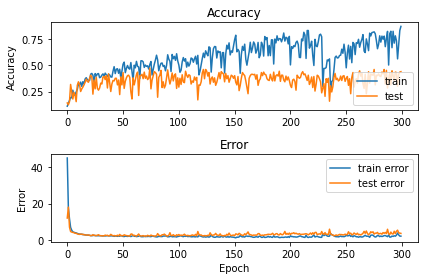

0.4406779661016949
CPU times: user 4min 48s, sys: 2min 14s, total: 7min 3s
Wall time: 8min 2s


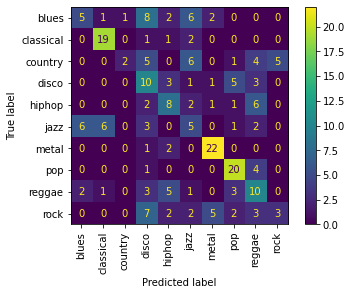

In [40]:
%%time
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(trainX.shape[1], trainX.shape[2])),
    tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', 
                          activation='selu', 
                          kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.01),
    tf.keras.layers.Dense(256, kernel_initializer='lecun_normal', 
                          activation='selu', 
                          kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.02),
    tf.keras.layers.Dense(128, kernel_initializer='lecun_normal', 
                          activation='selu', 
                          kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.01),
    tf.keras.layers.Dense(64, kernel_initializer='lecun_normal', 
                          activation='selu', 
                          kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.01),
    tf.keras.layers.Dense(10, activation = "linear")
])
## get output layer as logits for each class 
##(we can use softmax to get probabilities, but doing so makes model unstable:
# https://www.tensorflow.org/tutorials/quickstart/beginner
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
fit = model.fit(trainX, trainY,
         validation_data = (testX,testY),
                 epochs = 300)

plot_results(fit)
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(testX)
pred_labels = [np.argmax(prediction) for i,prediction in enumerate(predictions)]

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

ConfusionMatrixDisplay.from_predictions(
    y_true = [inv_labels[e] for i,e in enumerate(testY)],
    y_pred = [inv_labels[e] for i,e in enumerate(pred_labels)], 
    xticks_rotation= "vertical")
print(accuracy_score(testY,pred_labels))

### Selu with BatchNormalization

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 165504)            0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               84738560  
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)             

23/23 [==============================] - 2s 72ms/step - loss: 2.5408 - accuracy: 0.8760 - val_loss: 41.5956 - val_accuracy: 0.1059
Epoch 47/100
23/23 [==============================] - 2s 70ms/step - loss: 2.5438 - accuracy: 0.8785 - val_loss: 56.5699 - val_accuracy: 0.0975
Epoch 48/100
23/23 [==============================] - 2s 71ms/step - loss: 2.5836 - accuracy: 0.8940 - val_loss: 11.3572 - val_accuracy: 0.2119
Epoch 49/100
23/23 [==============================] - 2s 70ms/step - loss: 2.4148 - accuracy: 0.8841 - val_loss: 19.5264 - val_accuracy: 0.0847
Epoch 50/100
23/23 [==============================] - 2s 72ms/step - loss: 2.8404 - accuracy: 0.7927 - val_loss: 17.2578 - val_accuracy: 0.1059
Epoch 51/100
23/23 [==============================] - 2s 71ms/step - loss: 3.0311 - accuracy: 0.8533 - val_loss: 28.8528 - val_accuracy: 0.1059
Epoch 52/100
23/23 [==============================] - 2s 71ms/step - loss: 2.7262 - accuracy: 0.9281 - val_loss: 11.7153 - val_accuracy: 0.1229
Epoch

<Figure size 1440x1080 with 0 Axes>

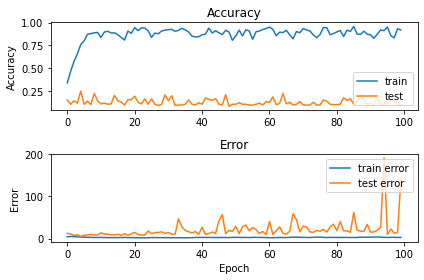

0.1016949152542373
CPU times: user 1min 43s, sys: 45.1 s, total: 2min 28s
Wall time: 2min 46s


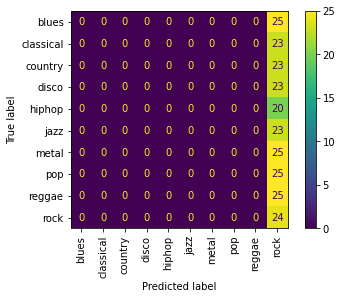

In [42]:
%%time
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(trainX.shape[1], trainX.shape[2])),
    tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', 
                          activation='selu', 
                          kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, kernel_initializer='lecun_normal', 
                          activation='selu', 
                          kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, kernel_initializer='lecun_normal', 
                          activation='selu', 
                          kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, kernel_initializer='lecun_normal', 
                          activation='selu', 
                          kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation = "linear")
])
## get output layer as logits for each class 
##(we can use softmax to get probabilities, but doing so makes model unstable:
# https://www.tensorflow.org/tutorials/quickstart/beginner
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
fit = model.fit(trainX, trainY,
         validation_data = (testX,testY),
                 epochs = 100)

plot_results(fit)
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(testX)
pred_labels = [np.argmax(prediction) for i,prediction in enumerate(predictions)]

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

ConfusionMatrixDisplay.from_predictions(
    y_true = [inv_labels[e] for i,e in enumerate(testY)],
    y_pred = [inv_labels[e] for i,e in enumerate(pred_labels)], 
    xticks_rotation= "vertical")
print(accuracy_score(testY,pred_labels))

### Thus, the best predictions are around 50% when using only the MFCC.